## MediPal -- Add Agentic Elements

### In this section, I added agentic elements to the multi-vector retriever to make it an agentic retriever for medical documents.

Why I need **Agentic elements**?

Becuase normal retriever can only search similar documents by query. If the query contains no relevant information, it is not able to retrieve right documents.

##### **Problem description**:

In real life conversation, users ask unpredictable questions. 

For example:
In the third turn, the user really want to ask 'How do I take Phenylephrine?'

But he inputs 'How do I take it?'. From the context, 'it' means 'Phenylephrine'.

If we retrieve documents by query 'How do I take it?', we would get unrelevant document. 'How do I take Phenylephrine?' makes more sense.

Other scenarios:

1. The users might just greet or speak without any question.
2. User might ask a random question in the middle of conversation.
3. .........

##### Analysis:

**The root problem is:** 
1. How to determine whether a query is a clinial/medical query?
2. How to convert an unclear query into a self-contained one, if the query is related to previous conversation.

##### Solution:

1. I decomposed this problem into a series of yes/no questions so that retrieval process go to the right direction.   
2. I equiped LLM with memory to evaluate current situation and decide what to do next, until reaching the end.

![](../assets/screenshots/agentic_retriever.PNG "")


##### The biggest trouble is how to make a good prompt for each evaluation note.

Approach was working with ChatGPT to improve prompts and test, until got ones.

In [ ]:
# My own libraries
from src.mytools import best_dtype, best_device, login_huggingface, draw_langgraph, logging_print
from src.rerank_retriever import Rerank_Retriever
from src import settings
from src.settings import AgentState, Short_Term_Memory
# My own libraries

import os
import json
import re
import random
from typing import Any, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.chat_history import BaseChatMessageHistory
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain.output_parsers import OutputFixingParser
from langchain_community.tools import WikipediaQueryRun, BraveSearch
from langchain_community.utilities import WikipediaAPIWrapper

In [ ]:
#model_id = "ContactDoctor/Bio-Medical-Llama-3-8B"
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

In [3]:
login_huggingface() 

Login HuggingFace!


In [4]:
# Load a HuggingFace model. Inference it from local GPU.

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype = best_dtype(),
    device_map={"":best_device()},     
    low_cpu_mem_usage=True     
)

tokenizer.pad_token = tokenizer.eos_token
print("Load tokenizer and base model done!")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Load tokenizer and base model done!


In [5]:
print(model)                    # full architecture tree (long but useful)
print(model.config)             # core hyperparameters (dims, layers, heads…)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [5]:
original_pipeline = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer,  
    temperature=0.1,   # Lower temp, better structued output
    return_full_text=False,   
)

# Wrapper normal piple with huggingfacepipeline
hug_pipeline = HuggingFacePipeline(pipeline=original_pipeline)

master_llm = ChatHuggingFace(llm=hug_pipeline) # It is the brain of the whole system

Device set to use cuda


### Master LLM is ready. Next retriever....

In [7]:
rag = Rerank_Retriever()
rag.setup_retriever()

setup_retriever starts runing!
Login HuggingFace!
load_embedding_model starts runing!
load_embedding_model took 4.0222s
load_crossencoder starts runing!
load_crossencoder took 1.2962s
setup_retriever took 6.7988s


In [8]:
wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [9]:
brave_api_key = os.getenv("BRAVE_SEARCH_KEY")
brave = BraveSearch.from_api_key(api_key=brave_api_key, search_kwargs={"count": 3})

In [ ]:
# Convert a history chat message to a string
def history_as_text(history: BaseChatMessageHistory) -> str:
    """convert history messsages into a string"""
    return "\n".join([
        f"{m.type.upper()}: {m.content[:200]}"   # e.g. "HUMAN: …" or "Master_Agent: …"
        for m in history.messages[::-1]])

In [12]:
# Initialize a global short-term memory for all users
settings.SHORT_TERM_MEMORY = Short_Term_Memory()

In [13]:
# Unit test function

def unit_test(action_func, decide_function):
    questions = [
        "Why doesn't my friend play tennis with me?",
        "What is the tallest mountain in South America?",        
        "Can you explain how blockchain technology works?",
        "It is not a good idea."      
        "My nasal is disconfort. Do you have a medicine to relieve sinus congestion and pressure?",        
        "How can I take it?",
        "Which symptoms usually appear first in a case of seasonal influenza?",        
        "what do you recommend?",
        "What are the warning signs of a severe allergic reaction?",
        "The project is reaching the deadline."       
    ]

    session_id = 1
    settings.STEP = 1

    for query in questions:
        state = AgentState(session_id=session_id,query=query,wiki_used=False,brave_used=False,rewrite_counter=0)
        state = action_func(state)
        result = decide_function(state)
        print(f"Decision: {result} \n")
        print(f"State: {state} \n")

#### Local and small LLMs usually has no robust structured output. So I have to prepare for all possible results it might output.

In [14]:
def _normalize_score(text: str) -> str:
    """Force 'yes'/'no' from messy text."""
    t = text.strip().lower()
    if t in {"yes", "y", "true","ok", "1"}:
        return "yes"
    if t in {"no", "n", "false", "0"}:
        return "no"
    # heuristics: ambiguous/under-specified → "no"
    return "no"

def _extract_json_like(s: str) -> Dict[str, Any]:
    """
    Try hard to find {"score": "..."} inside messy output.
    """
    # 1) quick regex for a minimal JSON object with score
    m = re.search(r'\{[^{}]*"score"\s*:\s*"(?P<score>yes|no|true|false)"[^{}]*\}', s, flags=re.I)
    if m:
        return {"score": _normalize_score(m.group("score"))}

    # 2) fall back: if the model just said "yes"/"no" without JSON
    yn = re.search(r'\b(yes|no|true|false)\b', s, flags=re.I)
    if yn:
        return {"score": _normalize_score(yn.group(1))}

    # 3) last resort default
    return {"score": "no"}

def robust_binary_grader(prompt: PromptTemplate, **kwargs) ->dict:
    """ 
    Make sure robustly parse the grade result of Local LLM 
    """
    # Base parser (strict JSON with a single key)
    base_parser = JsonOutputParser(pydantic_object=None, json_kwargs={"strict": False})
    # Auto-fixing parser: if model outputs invalid JSON, it asks the LLM to repair
    fixing_parser = OutputFixingParser.from_llm(parser=base_parser, llm=master_llm)
       # Lower temperature for determinism
    chain = prompt | master_llm | fixing_parser
    result = None
    try:
        args = {name: value for name, value in kwargs.items()}
        result = chain.invoke(args)          
        logging_print(f"Real output: {result}\n")        
        # result may already be a dict (from parser), but be defensive:
        if isinstance(result, dict) and "score" in result:
            score = _normalize_score(str(result["score"]))
            return {"score": score}  # exact contract            

        # If parser returned a string (some models), try to json-load or extract
        if isinstance(result, str):
            try:
                json_obj = _extract_json_like(result)
                score = _normalize_score(str(json_obj.get("score", "")))
                return {"score": score}                
            except Exception:
                pass
        # Fall through to the worst baseline
        if any(r in str(result).lower() for r in ["yes", "true"]):
            return {"score": "yes"}
        else:
            return {"score": "no"}       

    except Exception as e:
        # Hard fallback path if LLM/parse fails entirely
        logging_print(f"[grade_selfcontained_query] Warning: parse failed: {e} \n") 

        return {"score": "no"}

In [15]:
def _clean_one_line_question(text: str, fallback: str, max_len: int = 100) -> str:
    """
    Make whatever the LLM returned into a clean single-line question.
    - strip code fences, quotes, labels
    - collapse whitespace
    - take the first question-looking sentence if multiple
    - ensure it ends with '?'
    - length-limit (soft)
    """
    if not isinstance(text, str):
        text = str(text or "")

    t = text.strip()

    # remove common code fences or labels
    t = re.sub(r"^`{3,}.*?\n|\n`{3,}$", "", t, flags=re.S)        # ```...```
    t = re.sub(r"^(re.?written|improved|final|answer)\s*:\s*", "", t, flags=re.I)
    t = re.sub(r"^\"|\"$", "", t)  # trim surrounding quotes
    t = re.sub(r"^'+|'+$", "", t)  # trim surrounding single quotes

    # collapse to one line
    t = " ".join(t.split())

    # If LLM returned multiple sentences, try to pick the first question-like sentence.
    # Prefer the first chunk that ends with '?'
    m = re.search(r"([^?]{3,}\?)", t)
    if m:
        t = m.group(1).strip()

    # If still no question mark, try to cut at a sentence boundary and add '?'
    if "?" not in t:
        # take up to first period/exclamation if present, else keep entire
        m2 = re.split(r"[.!]", t, maxsplit=1)
        candidate = m2[0].strip()
        # guard against empty
        if len(candidate) >= 3:
            t = candidate
        if not t.endswith("?"):
            t = t.rstrip("?") + "?"

    # truncate softly (avoid cutting mid-word)
    if len(t) > max_len:
        t = t[:max_len].rsplit(" ", 1)[0].rstrip("?,.;:! ") + "?"

    # last resort fallback
    if len(t) < 3:
        t = fallback.strip()
        if not t.endswith("?"):
            t += "?"

    return t


def robust_question_generater(prompt: PromptTemplate, query: str, document: str = "") -> str:
    """ 
    Make sure robustly extract the question Local LLM generates.
    """
    chain = prompt | master_llm | StrOutputParser()
    try:
        raw = chain.invoke({"question": query, "document": document})
        logging_print(f"Real output: {raw}\n")
        result = _clean_one_line_question(raw, fallback=query, max_len=200)
        return result
    except Exception:
        # hard fallback: if model call fails, return original as a question
        return query if query.endswith("?") else (query + "?")

In [16]:
def wiki_to_json(s: str):
    """ 
    convert the docs from Wikipedia into a list of json objects
    """
    records = [r.strip() for r in s.strip().split("\n\n") if r.strip()]

    data = []
    for record in records:
        page_match = re.search(r"Page:\s*(.+)", record)
        summary_match = re.search(r"Summary:\s*(.+)", record, re.DOTALL)
        if page_match and summary_match:
            data.append({
                "Page": page_match.group(1).strip(),
                "Summary": summary_match.group(1).strip()
            })

    return data

In [17]:
#Action Node
def grade_selfcontained_query(state: AgentState) -> AgentState:
    """
    Determine whether a query is meaningful, clear, and self-contained
    without relying on prior conversation context.    
    """
    query = state["query"]

    logging_print(f"===Step {settings.STEP}===\n")
    logging_print(f"""Master_Agent: I will check if the query is self-contained.\n""")  
     
    prompt = PromptTemplate(
        template="""You are a grader for a question.
    You must decide whether the question is self-contained—meaning that it is clear, meaningful, and understandable on its own, without any conversation history or external context.
    Here is the user's question: {question} \n
    Return a binary judgment as a JSON object with a single key "score".
    Respond only with {{"score": "yes"}} if the question is self-contained,
    or {{"score": "no"}} if it is not. Do not include any explanation or extra text.""",
        input_variables=["question"],
    )

    state["grade"] = robust_binary_grader(prompt=prompt, question=query)
    settings.STEP += 1
    return state

In [18]:
#Decision Node
def decide_selfcontained_query(state: AgentState) -> str:
    """ 
    If it's a self-contained query, go to grader node for clinical checking.
    If it's not a self-contained query, go to grader node for history related checking. 
    """
    if state['grade']["score"] == "yes":
        logging_print(f"Master_Agent: The query is a self-contained one. We don't need to augment it. Let's check if it is a clinical query.\n")
        return "grade_clinical"
    else:
        logging_print(f"Master_Agent: The query is not self-contained. Let's check if it is related to history conversation. \n")
        return "grade_related_history"

In [19]:
unit_test(grade_selfcontained_query, decide_selfcontained_query)

===Step 1===

Master_Agent: I will check if the query is self-contained.

Real output: {'score': 'yes'}

Master_Agent: The query is a self-contained one. We don't need to augment it. Let's check if it is a clinical query.

Decision: grade_clinical 

State: {'session_id': 1, 'query': "Why doesn't my friend play tennis with me?", 'wiki_used': False, 'brave_used': False, 'rewrite_counter': 0, 'grade': {'score': 'yes'}} 

===Step 2===

Master_Agent: I will check if the query is self-contained.

Real output: {'score': 'yes'}

Master_Agent: The query is a self-contained one. We don't need to augment it. Let's check if it is a clinical query.

Decision: grade_clinical 

State: {'session_id': 1, 'query': 'What is the tallest mountain in South America?', 'wiki_used': False, 'brave_used': False, 'rewrite_counter': 0, 'grade': {'score': 'yes'}} 

===Step 3===

Master_Agent: I will check if the query is self-contained.

Real output: {'score': 'yes'}

Master_Agent: The query is a self-contained one

In [20]:
#Action Node
def grade_clinical_query(state: AgentState) -> AgentState:
    """
    Determine whether a query is about medicine, clinical questions
    without relying on prior conversation context.    
    """
    query = state["query"]

    logging_print(f"===Step {settings.STEP}===\n")
    logging_print(f"Master_Agent: I am checking if the query is about medicine or clinical questions.\n")     

    prompt = PromptTemplate(
        template="""You are a grader for a user message.
    Decide whether the message is about a medical or health-related topic.

    Consider it **medical** if it involves ANY of the following:
    - Symptoms, illnesses, injuries, or physical/mental discomfort (e.g., “I have a headache”, “I feel anxious”)
    - Diagnosis, treatment, medications, dosage, side effects, or drug interactions
    - Tests, lab results, medical procedures, surgeries
    - Preventive care, pregnancy/breastfeeding guidance, vaccination
    - Psychological or mental-health issues, therapy, counseling
    - Any advice, risk assessment, or triage about human or animal health

    Consider it **non-medical** if it is about:
    - Pure biology or academic science without personal health context
    - Health-related news/trivia without asking for medical guidance
    - Insurance, scheduling, or administrative tasks
    - Completely unrelated topics

    User message:
    {question}

    Return only a JSON object with a single key "score":
    - {{"score": "yes"}} if it is medical/clinical/health-related
    - {{"score": "no"}} if it is not

    Do not add any explanation or extra text.""",
        input_variables=["question"],
    )


    state["grade"] = robust_binary_grader(prompt=prompt, question=query)
    settings.STEP += 1
    return state

In [21]:
#Decision Node
def decide_clinical_query(state: AgentState) -> str:
    """ 
    If it is a clinical query and self-contained, go to retrieve node directly.
    If it is not a clinical query at all, go to return_sorry node.
    """
    if state['grade']["score"] == "yes":
        logging_print(f"Master_Agent: The query is a clinical one. We will try to retrive documents now.\n")
        return "retrieve"
    else:
        logging_print(f"Master_Agent: The query is not clinical query. I can do nothing with it. \n")
        return "return_sorry"

In [22]:
unit_test(grade_clinical_query, decide_clinical_query)

===Step 1===

Master_Agent: I am checking if the query is about medicine or clinical questions.



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Real output: {'score': 'no'}

Master_Agent: The query is not clinical query. I can do nothing with it. 

Decision: return_sorry 

State: {'session_id': 1, 'query': "Why doesn't my friend play tennis with me?", 'wiki_used': False, 'brave_used': False, 'rewrite_counter': 0, 'grade': {'score': 'no'}} 

===Step 2===

Master_Agent: I am checking if the query is about medicine or clinical questions.

Real output: {'score': 'no'}

Master_Agent: The query is not clinical query. I can do nothing with it. 

Decision: return_sorry 

State: {'session_id': 1, 'query': 'What is the tallest mountain in South America?', 'wiki_used': False, 'brave_used': False, 'rewrite_counter': 0, 'grade': {'score': 'no'}} 

===Step 3===

Master_Agent: I am checking if the query is about medicine or clinical questions.

Real output: {'score': 'no'}

Master_Agent: The query is not clinical query. I can do nothing with it. 

Decision: return_sorry 

State: {'session_id': 1, 'query': 'Can you explain how blockchain tech

In [23]:
#Action Node
def grade_history_related_query(state: AgentState) -> AgentState:
    """
    Determine whether a query is related to history conversations.    
    """
    query = state["query"]
    history = settings.SHORT_TERM_MEMORY.get_history(state["session_id"])
    history_conversation = history_as_text(history)

    logging_print(f"===Step {settings.STEP}===\n")
    logging_print(f"Master_Agent: I am checking if the query is related to history conversations. \n")   
    logging_print(f"history conversations: {history_conversation} \n")   

    prompt = PromptTemplate(
        template="""You are a conversation coherence grader.
        Your task is to decide whether the user's latest message is logically and topically connected to the previous conversation.

        Conversation history:
        {document}

        User's latest message:
        {question}

        Return only a JSON object with a single key "score":
        - {{"score": "yes"}} if the latest message is coherent and contextually related to the conversation history.
        - {{"score": "no"}} if it is not related or breaks the context.

        No explanation or extra text.""",
        input_variables=["document", "question"],
    )    

    state["grade"] = robust_binary_grader(prompt=prompt, question=query, document=history_conversation)
    settings.STEP += 1
    return state

In [24]:
#Decision Node
def decide_history_related_query(state: AgentState) -> str:
    """ 
    If the query is related to the history conversation, but it is not self-contained. Go to rewrite node to augment the query.
    If the query is not related to the history. Go to "return_sorry" node.
    """    
    if state['grade']["score"] == "yes" and state["rewrite_counter"] < 3:
        logging_print(f"Master_Agent: The query is related to the history. But it is not self-contained. Let's re-write it.\n")
        return "rewrite"
    else:
        logging_print(f"Master_Agent: The query is not related to the history. So I can do nothing. \n")
        return "return_sorry"

In [25]:
# Testing
#history = settings.SHORT_TERM_MEMORY.get_history(session_id = 1)
settings.SHORT_TERM_MEMORY.add_message(session_id=1,message="hi, there!", msg_type="human")
settings.SHORT_TERM_MEMORY.add_message(session_id=1,message="hi, how can I help you?", msg_type="ai")
settings.SHORT_TERM_MEMORY.add_message(session_id=1,message="My nasal is disconfort. Do you have a medicine to relieve sinus congestion and pressure?", msg_type="human")
settings.SHORT_TERM_MEMORY.add_message(session_id=1,message="phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. it is also used to relieve sinus congestion and pressure. phenylephrine will relieve symptoms but will not treat the cause of the symptoms or speed recovery. phenylephrine is in a class of medications called nasal decongestants. it works by reducing swelling of the blood vessels in the nasal passages.about Phenylephrine", msg_type="ai")

In [26]:
# Should be related to history
state = AgentState(session_id=1, query="How can I take it?",wiki_used=False,rewrite_counter=0)

state = grade_history_related_query(state)

result = decide_history_related_query(state)

print(f"Decision: {result} \n")
print(f"State: {state} \n")
# Related case
state = AgentState(session_id=1, query="where can I buy it?",wiki_used=False,rewrite_counter=0)

state = grade_history_related_query(state)

result = decide_history_related_query(state)

print(f"Decision: {result} \n")
print(f"State: {state} \n")

===Step 10===

Master_Agent: I am checking if the query is related to history conversations. 

history conversations: AI: phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. it is also used to relieve sinus congestion and pressure. phenylephrine will relieve symptoms but will not 
HUMAN: My nasal is disconfort. Do you have a medicine to relieve sinus congestion and pressure? 

Real output: {'score': 'yes'}

Master_Agent: The query is related to the history. But it is not self-contained. Let's re-write it.

Decision: rewrite 

State: {'session_id': 1, 'query': 'How can I take it?', 'wiki_used': False, 'rewrite_counter': 0, 'grade': {'score': 'yes'}} 

===Step 11===

Master_Agent: I am checking if the query is related to history conversations. 

history conversations: AI: phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. it is also used to relieve sinus congestion and pressure. phenylephrine will relieve 

In [27]:
# Should be not related to history
state = AgentState(session_id=1, query="Why doesn't my friend play tennis with me?",wiki_used=False,rewrite_counter=0)

state = grade_history_related_query(state)

result = decide_history_related_query(state)

print(f"Decision: {result} \n")
print(f"State: {state} \n")

===Step 12===

Master_Agent: I am checking if the query is related to history conversations. 

history conversations: AI: phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. it is also used to relieve sinus congestion and pressure. phenylephrine will relieve symptoms but will not 
HUMAN: My nasal is disconfort. Do you have a medicine to relieve sinus congestion and pressure? 

Real output: {'score': 'no'}

Master_Agent: The query is not related to the history. So I can do nothing. 

Decision: return_sorry 

State: {'session_id': 1, 'query': "Why doesn't my friend play tennis with me?", 'wiki_used': False, 'rewrite_counter': 0, 'grade': {'score': 'no'}} 



In [ ]:
# Should be related to history
state = AgentState(session_id=1, query="How can I take it?",wiki_used=False,rewrite_counter=0)

state = grade_history_related_query(state)

result = decide_history_related_query(state)

print(f"Decision: {result} \n")
print(f"State: {state} \n")

In [28]:
#Action Node
def rewrite_query(state: AgentState) -> AgentState:
    """
    Determine whether a query is related to history conversations.    
    """
    query = state["query"]
    history = settings.SHORT_TERM_MEMORY.get_history(state["session_id"])
    history_conversation = history_as_text(history)

    logging_print(f"===Step {settings.STEP}===\n")
    logging_print(f"Master_Agent: I am rewriting the query so that I can retrieve relevant documents with a new query. \n")      
    
    prompt = PromptTemplate(
        template="""You are a question rewriter.
    Your goal is to make the user's question fully self-contained and clear
    by using the information provided in the reference material.

    Reference material:
    {document}

    Original question:
    {question}

    Rewrite the question so that:
    - It preserves the original intent and meaning.
    - It includes any missing details from the reference material so the question can stand alone and be understood without reading the material.
    - It is concise and natural.

    Return only the rewritten question text with no explanation, no preamble, and no extra formatting.""",
        input_variables=["question", "document"],
    )

    new_query = robust_question_generater(prompt=prompt, query=query, document=history_conversation)
    state['rewrite_counter'] += 1
    state = AgentState(session_id=state["session_id"], query=new_query, rewrite_counter=state['rewrite_counter']) # Avoid infinity loop in graph.
    settings.STEP += 1
    return state

In [ ]:
state = AgentState(session_id=1, query="How can I take it?",rewrite_counter=0)

state = rewrite_query(state)

print(f"State: {state} \n")

state = AgentState(session_id=1, query="Where can I buy it?",rewrite_counter=0)

state = rewrite_query(state)

print(f"State: {state} \n")

===Step 13===

Master_Agent: I am rewriting the query so that I can retrieve relevant documents with a new query. 

Real output:  Do you have a medicine to relieve sinus congestion and pressure?

State: {'session_id': 1, 'query': 'Do you have a medicine to relieve sinus congestion and pressure?', 'rewrite_counter': 1} 

===Step 14===

Master_Agent: I am rewriting the query so that I can retrieve relevant documents with a new query. 

Real output:  Can I buy phenylephrine to relieve nasal discomfort and sinus congestion?

State: {'session_id': 1, 'query': 'Can I buy phenylephrine to relieve nasal discomfort and sinus congestion?', 'rewrite_counter': 1} 



In [ ]:
#Action Node
def return_without_docs(state: AgentState) -> AgentState:
    """ 
    When the query has nothing to do with clinical topic or retrieval documents are not relevant to the query, 
    Then return 'sorry...' 
    """
    logging_print(f"===Step {settings.STEP}===\n")
    apology_sentences = [    
        "We mainly provide information on medicines and medical topics. Your question may be beyond my scope of work. I apologize for not being able to provide more information.",
        "Our focus is on drug and medical information. Your question may be beyond my scope of work. I apologize for not being able to provide more information.",
        "We specialize in medication and medical information. Your question may be beyond my scope of work. I apologize for not being able to provide more information.",
        "We mainly handle information about medications and health care. Your question may be beyond my scope of work. I apologize for not being able to provide more information."        
    ]

    state["retrieved_doc"] = random.choice(apology_sentences)
    logging_print(f"""Master_Agent: {state["retrieved_doc"]}""")
    settings.STEP += 1
    return state

In [32]:
#Action Node
def save_to_memory(state: AgentState) -> AgentState:
    """ 
    Before End, save user's query and final answer to memory 
    """   
    logging_print(f"===Step {settings.STEP}===\n")
    logging_print("Master_Agent: I am saving the user query and retrieved docs to memory.\n")      

    settings.SHORT_TERM_MEMORY.add_message(session_id=state["session_id"], message=state["query"], msg_type="human")
    settings.SHORT_TERM_MEMORY.add_message(session_id=state["session_id"], message=state["retrieved_doc"], msg_type="ai")
    #settings.STEP = 1 # Reset the STEP 
    return state  

In [33]:
#Action Node
def retrieve(state: AgentState) -> AgentState:
    """ 
    Retrieve documents by query.
    Then grade the relevance.
    """

    logging_print(f"===Step {settings.STEP}===\n")
    logging_print("Master_Agent: I am seaching documents from RAG.\n")  
    documents = rag.retrieve(state["query"], top_k=3)
    final_documents = [d.page_content for d in documents if d.metadata["rerank_score"] > 0.7]
    state["retrieved_doc"] = ". ".join(final_documents)
    if len(final_documents) == 0:        
        state["grade"] = {"score": "no"}
    else:
        state["grade"] = {"score": "yes"}

    settings.STEP += 1

    return state    

In [34]:
#Decision Node
def decide_relevant_docs(state: AgentState) -> str:
    """ 
    If it retrieved relevant documents from RAG, go to "save_node"
    If it didn't find anything from RAG and Wiki tool has not been used, then go to "wiki_search" tool node.
    If it didn't find anything from RAG and Wiki, the return sorry.
    """
    if state["grade"]["score"] == "yes":
        logging_print(f"Master_Agent: I found some documents you may need.\n")
        return "save_node"
    elif not state["wiki_used"]:
        logging_print("Master_Agent: I am sorry I didn't get the relevant document from RAG. I am going to search on wikipedia.\n")          
        return "wiki_search"
    elif not state["brave_used"]:
        logging_print("Master_Agent: I only have last tool to use now..\n")          
        return "brave_search"
    else:
        logging_print("Master_Agent: I am sorry I didn't get any thing from RAG, Brave search and wikipedia.\n")         
        return "return_sorry"

In [35]:
#Action Node
def wiki_search(state: AgentState) -> AgentState:
    """ 
    Search documents by Wikipedia seach tool.
    Then grade the relevance.
    """

    logging_print(f"===Step {settings.STEP}===\n")
    logging_print("I am seaching documents from Wikipedia.\n")  
    documents = wiki.invoke({"query": state["query"]})
    json_list = wiki_to_json(documents)
    
    # Rank the wiki docs with crossEncoder
    pairs = [[state["query"], s["Summary"]] for s in json_list]
    scores = rag.cross_encoder.predict(pairs, batch_size=32)
    for j_l, score in zip(json_list, scores):
        j_l["score"] = float(score)

    final_documents = [d["Summary"] for d in json_list if d["score"] > 0.5]
    state["retrieved_doc"] = ". ".join(final_documents)
    state["wiki_used"] = True # For a good query, only use wiki search once. Avoid infinity loop.
    if len(final_documents) == 0:        
        state["grade"] = {"score": "no"}
    else:        
        state["grade"] = {"score": "yes"}

    settings.STEP += 1

    return state

In [36]:
#Action Node
def brave_search(state: AgentState) -> AgentState:
    """ 
    Search documents by Brave seach tool.
    Then grade the relevance.
    """

    logging_print(f"===Step {settings.STEP}===\n")
    logging_print("I am seaching documents from Brave search Engine.\n")  
    
    json_list = json.loads(brave.run(state["query"]))
    
    # Rank the brave docs with crossEncoder
    pairs = [[state["query"], d["snippet"]] for d in json_list]
    scores = rag.cross_encoder.predict(pairs, batch_size=32)
    for j_l, score in zip(json_list, scores):
        j_l["score"] = float(score)

    final_documents = [d["snippet"] for d in json_list if d["score"] > 0.5]
    state["retrieved_doc"] = ". ".join(final_documents)
    state["brave_used"] = True # For a good query, only use brave search once. Avoid infinity loop.
    if len(final_documents) == 0:        
        state["grade"] = {"score": "no"}
    else:        
        state["grade"] = {"score": "yes"}

    settings.STEP += 1

    return state

In [37]:
#Decision Node
def decide_entry_relevant(state: AgentState) -> str:
    """ 
    No matter what the query looks like. Just retrieve something to see if we can get relevant documents.
    This is the most efficient way. 
    """    
    if state["grade"]["score"] == "yes":
        print(f"Master_Agent: I found some documents you may need.\n")
        return "return_with_docs"    
    else:               
        return "grade_selfcontained"

In [38]:
# Define graph
agentic_rag_graph = StateGraph(AgentState)
# Add nodes

agentic_rag_graph.add_node("grade_selfcontained_node", grade_selfcontained_query)

agentic_rag_graph.add_node("decide_selfcontained_router", lambda state: state)

agentic_rag_graph.add_node("grade_history_related_node", grade_history_related_query)

agentic_rag_graph.add_node("decide_history_related_router", lambda state: state)

agentic_rag_graph.add_node("rewrite_query_node", rewrite_query)

agentic_rag_graph.add_node("grade_clinical_node", grade_clinical_query)

agentic_rag_graph.add_node("decide_clinical_router", lambda state: state)

agentic_rag_graph.add_node("retrieve_node", retrieve)

agentic_rag_graph.add_node("decide_relevant_router", lambda state:state) # Transparent

agentic_rag_graph.add_node("return_sorry_node", return_without_docs)

#agentic_rag_graph.add_node("return_docs_node", return_with_docs)

agentic_rag_graph.add_node("save_node", save_to_memory)

agentic_rag_graph.add_node("wiki_search_node", wiki_search)

agentic_rag_graph.add_node("brave_search_node", brave_search)

# Add Edges

agentic_rag_graph.add_edge(START, "grade_selfcontained_node")

agentic_rag_graph.add_edge("grade_selfcontained_node", "decide_selfcontained_router")

agentic_rag_graph.add_conditional_edges(
    source="decide_selfcontained_router",
    path=decide_selfcontained_query,
    path_map={
        "grade_clinical": "grade_clinical_node",
        "grade_related_history": "grade_history_related_node"
    }
)

agentic_rag_graph.add_edge("grade_history_related_node", "decide_history_related_router")

agentic_rag_graph.add_conditional_edges(
    source="decide_history_related_router",
    path=decide_history_related_query,
    path_map={
        "rewrite": "rewrite_query_node",
        "return_sorry": "return_sorry_node"
    }
)

agentic_rag_graph.add_edge("grade_clinical_node", "decide_clinical_router")

agentic_rag_graph.add_conditional_edges(
    source="decide_clinical_router",
    path=decide_clinical_query,
    path_map={
        "retrieve": "retrieve_node",
        "return_sorry": "return_sorry_node"
    }
)

agentic_rag_graph.add_edge("rewrite_query_node", "grade_selfcontained_node")

agentic_rag_graph.add_edge("retrieve_node", "decide_relevant_router")

agentic_rag_graph.add_conditional_edges(
    source="decide_relevant_router",
    path=decide_relevant_docs,
    path_map={
        "return_sorry": "return_sorry_node",
        "save_node": "save_node",
        "wiki_search": "wiki_search_node",
        "brave_search": "brave_search_node"
    }
)

agentic_rag_graph.add_edge("wiki_search_node", "decide_relevant_router")

agentic_rag_graph.add_edge("brave_search_node", "decide_relevant_router")

agentic_rag_graph.add_edge("return_sorry_node", "save_node")

#agentic_rag_graph.add_edge("return_docs_node", "save_node")

agentic_rag_graph.add_edge("save_node", END)

app = agentic_rag_graph.compile()

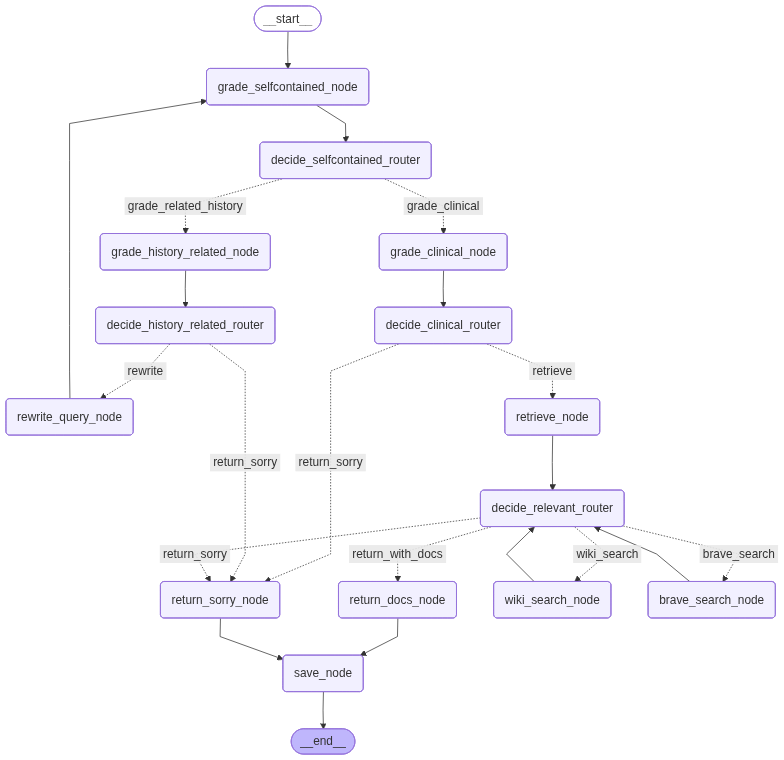

In [44]:
draw_langgraph(app)

In [ ]:
draw_langgraph(app, inline=False)

In [42]:
def call_rag(query: str):
    state = AgentState(query=query, session_id=1,wiki_used=False,brave_used=False,rewrite_counter=0)
    result = app.invoke(state)
    print(f"result:{result}")

In [43]:
questions = [    
"Is there anything I can assist you with?\n",    
"Can I help you in any way, next?\n",
"Do you have any questions?\n",  
"Are you looking for any particular information?\n",
"I am a Medicine Agentic RAG. I can help you get medical and clinical documents. Just tell me what you need?\n"
]
while True:
    print(f"RAG: {random.choice(questions)}")
    query = input("You: ")
    if query.strip().lower() in ["end", "exit"]:
        break
    call_rag(query)

RAG: Is there anything I can assist you with?

===Step 15===

Master_Agent: I will check if the query is self-contained.

Real output: {'score': 'no'}

Master_Agent: The query is not self-contained. Let's check if it is related to history conversation. 

===Step 16===

Master_Agent: I am checking if the query is related to history conversations. 

history conversations: AI: phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. it is also used to relieve sinus congestion and pressure. phenylephrine will relieve symptoms but will not 
HUMAN: My nasal is disconfort. Do you have a medicine to relieve sinus congestion and pressure? 

Real output: {'score': 'no'}

Master_Agent: The query is not related to the history. So I can do nothing. 

===Step 17===

Master_Agent: TWe mainly handle information about medications and health care. Your question may be beyond my scope of work. I apologize for not being able to provide more information.
===Step 18===

M

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Master_Agent: I found some documents you may need.

===Step 21===

Master_Agent: I am saving the user query and retrieved docs to memory.

result:{'session_id': 1, 'query': 'My doctor let me take Phenylephrine. what is Phenylephrine used for?', 'retrieved_doc': "phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. it is usually taken every 4 hours as needed. follow the directions on your prescription label or the package label carefully, and ask your doctor or pharmacist to explain any part you do not understand. take phenylephrine exactly as directed. do not take more or less of it or take it more often than prescribed by your doctor or directed on the label.phenylephrine comes alone and in combination with other medications. ask your doctor or pharmacist for advice on which product is best for your symptoms. check nonprescription cough and cold product labels carefully before using two or more products at the same time. these products may contain the sam

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Master_Agent: I found some documents you may need.

===Step 24===

Master_Agent: I am saving the user query and retrieved docs to memory.

result:{'session_id': 1, 'query': 'other uses for Phenylephrine?', 'retrieved_doc': 'Phenylephrine may be prescribed for other uses; ask your doctor or pharmacist for more information.', 'grade': {'score': 'yes'}, 'wiki_used': False, 'brave_used': False, 'rewrite_counter': 0}
RAG: I am a Medicine Agentic RAG. I can help you get medical and clinical documents. Just tell me what you need?

===Step 24===

Master_Agent: I will check if the query is self-contained.

Real output: {'score': 'no'}

Master_Agent: The query is not self-contained. Let's check if it is related to history conversation. 

===Step 25===

Master_Agent: I am checking if the query is related to history conversations. 

history conversations: AI: Phenylephrine may be prescribed for other uses; ask your doctor or pharmacist for more information.
HUMAN: other uses for Phenylephrine? 

R

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Master_Agent: I found some documents you may need.

===Step 30===

Master_Agent: I am saving the user query and retrieved docs to memory.

result:{'session_id': 1, 'query': 'How should I take Phenylephrine?', 'retrieved_doc': "phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. it is usually taken every 4 hours as needed. follow the directions on your prescription label or the package label carefully, and ask your doctor or pharmacist to explain any part you do not understand. take phenylephrine exactly as directed. do not take more or less of it or take it more often than prescribed by your doctor or directed on the label.phenylephrine comes alone and in combination with other medications. ask your doctor or pharmacist for advice on which product is best for your symptoms. check nonprescription cough and cold product labels carefully before using two or more products at the same time. these products may contain the same active ingredient(s) and taking th

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Master_Agent: I found some documents you may need.

===Step 36===

Master_Agent: I am saving the user query and retrieved docs to memory.

result:{'session_id': 1, 'query': 'What are the possible side effects of taking Phenylephrine?', 'retrieved_doc': "phenylephrine may cause side effects. some side effects can be serious. if you experience any of these symptoms, stop using phenylephrine and call your doctor:nervousnessdizzinesssleeplessnessphenylephrine may cause other side effects. call your doctor if you have any unusual problems while taking Phenylephrine.if you experience a serious side effect, you or your doctor may send a report to the food and drug administration's (fda) medwatch adverse event reporting program online (https://www.fda.gov/safety/medwatch) or by phone ([phone]).", 'grade': {'score': 'yes'}, 'wiki_used': False, 'brave_used': False, 'rewrite_counter': 1}
RAG: Can I help you in any way, next?

===Step 36===

Master_Agent: I will check if the query is self-containe

Batches: 0it [00:00, ?it/s]

Master_Agent: I am sorry I didn't get the relevant document from RAG. I am going to search on wikipedia.

===Step 39===

I am seaching documents from Wikipedia.



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Master_Agent: I only have last tool to use now..

===Step 40===

I am seaching documents from Brave search Engine.



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Master_Agent: I found some documents you may need.

===Step 41===

Master_Agent: I am saving the user query and retrieved docs to memory.

result:{'session_id': 1, 'query': 'I have a headache today. Any idea why?', 'retrieved_doc': '<strong>Dysfunction or over-activity of pain-sensitive features in your head cause primary headaches</strong>. They’re not a symptom of or caused by an underlying medical condition. Some people may have genes that make them more likely to develop primary headaches.. Nearly everyone has had headache ... over-the-counter pain reliever, some food or coffee, or a short rest. But <strong>if your headache is severe or unusual, you might worry about stroke, a tumor, or a blood clot</strong>..... <strong>Headache</strong>: Symptom — Overview covers definition, possible causes of this painful symptom.', 'grade': {'score': 'yes'}, 'wiki_used': True, 'brave_used': True, 'rewrite_counter': 0}
RAG: Do you have any questions?

